<a href="https://colab.research.google.com/github/yahuy1/CSE432/blob/main/HW7_Coding_nguyenhg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
from torchsummary import summary

GPU Settings

In [4]:
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

Download Data

In [5]:
# Preparing for Data
print('==> Preparing data..')

# Training Data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# Testing Data preparation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

==> Preparing data..


100%|██████████| 170498071/170498071 [00:05<00:00, 29642759.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Visualize Data

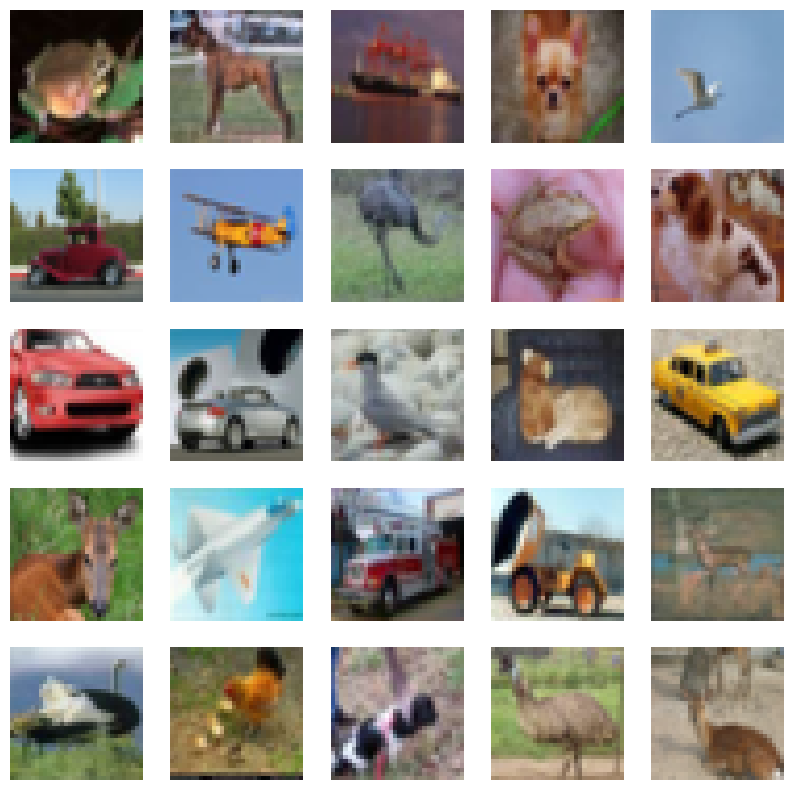

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle 

f = open('./data/cifar-10-batches-py/data_batch_1', 'rb')
datadict = cPickle.load(f,encoding='latin1')
f.close()
X = datadict["data"] 
Y = datadict['labels']
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
Y = np.array(Y)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])

Model

In [7]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    self.feature_extractor = nn.Sequential(  
            # C1
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 11, stride = 1, padding = 5),
            nn.ReLU(),
            # C2
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 7, stride = 1, padding = 3),
            nn.ReLU(),
            # C3
            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(),
            # C4
            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),
            nn.ReLU(),
            # MP1
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            # C5
            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),
            nn.ReLU(),
            # MP2
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            # C6
            nn.Conv2d(in_channels = 16, out_channels = 160, kernel_size = 5, stride = 1, padding = 0),
            nn.ReLU()
        )
    
    self.classifier = nn.Sequential(
            # FC1
            nn.Linear(in_features = 160, out_features = 160),
            nn.ReLU(),
            # FC2
            nn.Linear(in_features = 160, out_features = 10)
        )
  def forward(self, x):
    x = self.feature_extractor(x)
    x = torch.flatten(x, 1)
    logits = self.classifier(x)
    out = F.softmax(logits, dim=1)
    return out
  
model = LeNet().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]           2,912
              ReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3           [-1, 16, 32, 32]           6,288
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           6,416
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 28, 28]           6,416
              ReLU-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 16, 10, 10]           6,416
             ReLU-11           [-1, 16, 10, 10]               0
        MaxPool2d-12             [-1, 16, 5, 5]               0
           Conv2d-13            [-1, 160, 1, 1]          64,160
             ReLU-14            [-1, 16

Training & Testing

In [8]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()

  loss_Fn=nn.CrossEntropyLoss()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    Predict = model(data)
    loss = loss_Fn(Predict, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  scheduler.step()

def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
  
epochs = 50
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 25, gamma = 0.5)

for epoch in range(1, epochs + 1):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)




Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302691
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.302327
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.302720
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.302545

Test set: Average loss: -0.1000, Accuracy: 1000/10000 (10%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.302559
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.302054
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.303191
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.302682

Test set: Average loss: -0.1001, Accuracy: 1000/10000 (10%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.303078
Train Epoch: 3 [12800/50000 (26%)]	Loss: 2.302680
Train Epoch: 3 [25600/50000 (51%)]	Loss: 2.302708
Train Epoch: 3 [38400/50000 (77%)]	Loss: 2.302976

Test set: Average loss: -0.1002, Accuracy: 999/10000 (10%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.302143
Train Epoch: 4 [12800/50000 (26%)]	Loss: 2.302068
Train Epoch: 4 [25600/50000 (51%)]	Loss: 2.299706
Train Epoch: 4 [38400/50000 (77%)]	Loss: 2.263736

Test set: Average loss: -0.1646, A